### FFT readout of CW signals (BREAD firmware)

See examples to extract data from the different points.

![alt text](images/std_111_bread_small.png "Title")

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from spectrum import SpectrumSoc

from fft_helpers import *
from numpy.fft import fftshift, fft
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
# # this firmware has a tProc in addition to the BREAD CW chain
# soc = SpectrumSoc('/data/fw/2025-08-26_111_tprocv2r26_std-bread-small/pynq/std_111_bread_small.bit')

# this firmware only has a CW chain, it will not work with the "standard QICK" examples
soc = SpectrumSoc('/data/fw/fft/bread_real.bit', no_tproc=True)

# # this firmware also only has a CW chain
# # it omits some debug stuff (the MR buffer for raw ADC data, and the URAM buffer for raw FFT) but has the wxfft
# soc = SpectrumSoc('../pynq/spectrum_v1.bit', no_tproc=True)

soccfg = soc
print(soccfg)

QICK running on ZCU111, software version 0.2.367

Firmware configuration (built Wed Aug 20 16:19:34 2025):

	Global clocks (MHz): tProc dispatcher timing 0.000, RF reference 204.800
	Groups of related clocks: [DAC tile 1], [ADC tile 0]

	0 signal generator channels:

	1 constant-IQ outputs:
	0:	fs=6144.000 Msps
		DAC tile 1, blk 3 is DAC229_T1_CH3, or RF board DAC port 7

	0 readout channels:

SPECTRUM configuration:


	Board: ZCU111
	Analysis 0:
		ADC tile 0, blk 0 is ADC224_T0_CH0, or RF board ADC AC port 0
		fs = 4096.0 MHz, Decimation    = 2
		PFB: fs = 256.0 MHz, fc = 128.0 MHz, 16 channels


In [3]:
#########################
### Define dual chain ###
#########################
chain = DualChain(soc,soc['analysis'][0],soc['synthesis'][0])

In [4]:
chain.set_tone(1000,verbose=True)

F1 = 1000.025, Y1 = -20.824


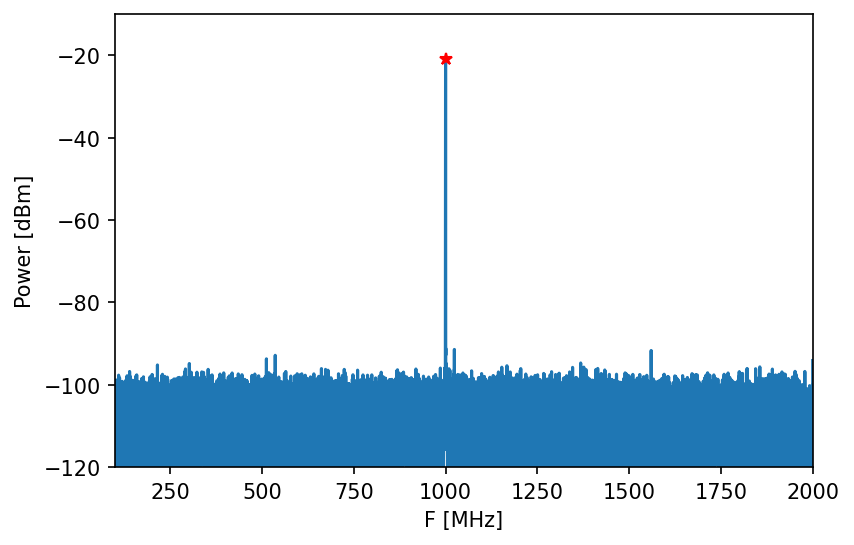

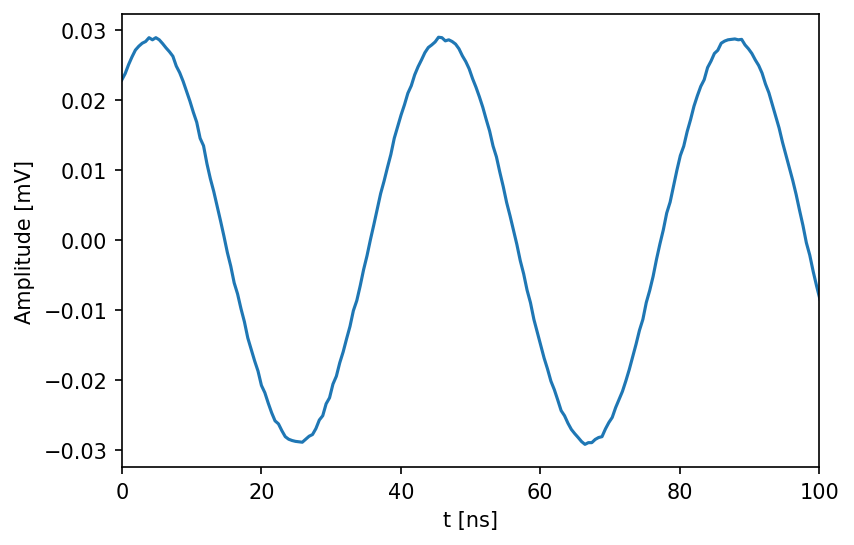

In [5]:
##########################################
### Simple Sine Loop-back (ADC output) ###
##########################################
# Get data.
[xi,xq] = chain.get_data_adc()
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(0,chain.fs,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(1,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");
plt.xlim([100,2000])
plt.ylim([-120,-10])

# Time domain signal.
n = np.arange(len(x))
t = n/chain.fs
plt.figure(2,dpi=150)
plt.plot(1000*t,np.real(x))
plt.xlabel("t [ns]");
plt.ylabel("Amplitude [mV]");
plt.xlim([0,100]);

F1 = 1000.002, Y1 = -2.641


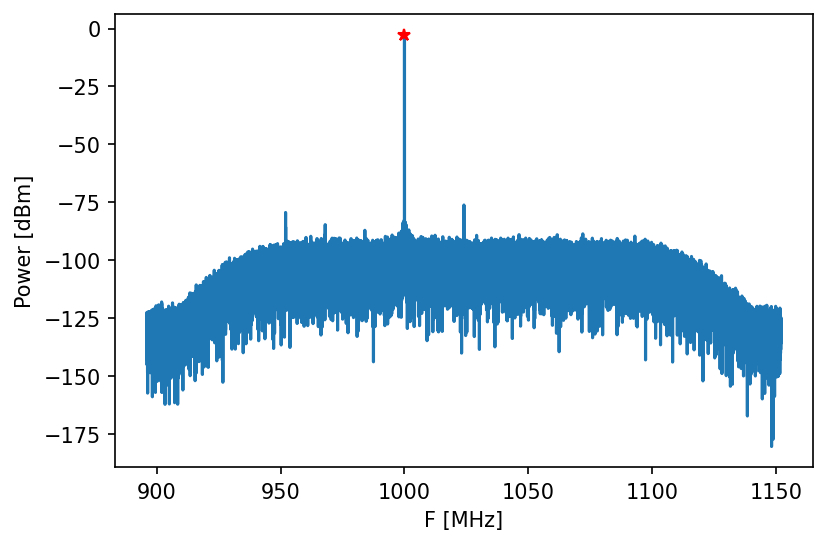

In [6]:
##########################################
### Simple Sine Loop-back (PFB output) ###
##########################################
fout = 1000

# Compute channel center frequency.
FC = chain.analysis.ch2freq(chain.analysis.freq2ch(fout))

# Get data.
[xi,xq] = chain.get_bin_pfb(fout)
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(3,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

Iteration K = 0
Iteration K = 1
Iteration K = 2
Iteration K = 3
Iteration K = 4
Iteration K = 5
Iteration K = 6
Iteration K = 7
Iteration K = 8
Iteration K = 9
Iteration K = 10
Iteration K = 11
Iteration K = 12
Iteration K = 13
Iteration K = 14
Iteration K = 15


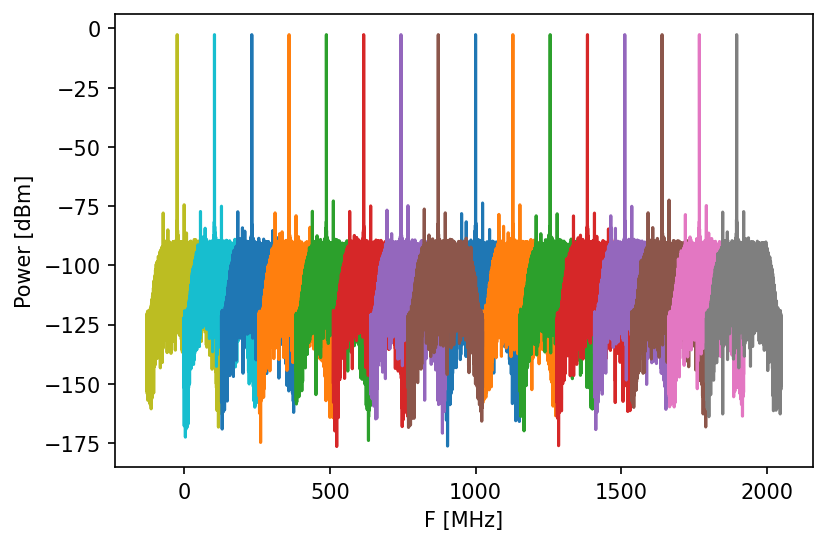

In [7]:
##########################################
### Channels Side-by-Side (PFB output) ###
##########################################
# Channels to plot.
K = np.arange(chain.nch)

plt.figure(4,dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    print("Iteration K = %d" %KK)  
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    # Get data.
    [xi,xq] = chain.get_bin_pfb(fck+1)
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15

    # Spectrum.
    w = np.hanning(len(x))
    Aw = len(w)/np.sum(w)
    xw = Aw*x*w
    Y = fftshift(fft(xw)/len(xw))
    F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

    # Normalize to dBm.
    R = 50;
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

F1 = 1000.003, Y1 = -2.641


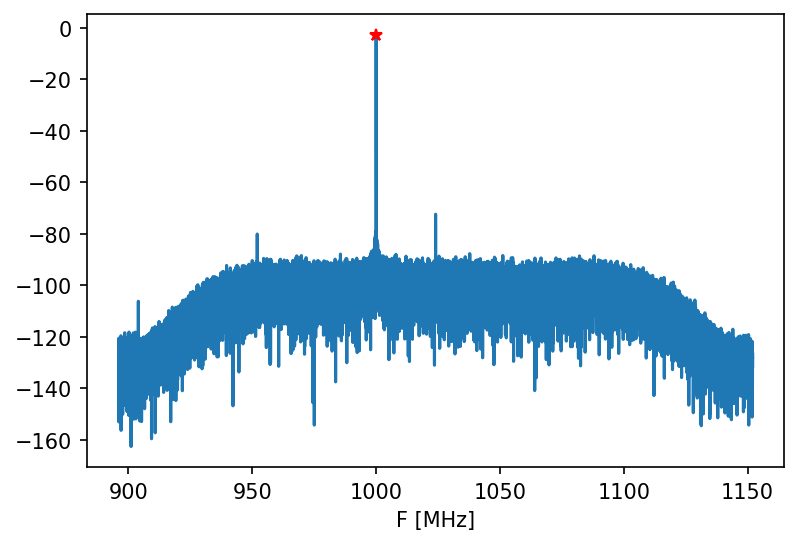

In [8]:
###########################################
### Simple Sine Loop-back (XFFT output) ###
###########################################
fout = 1000

# Compute channel center frequency.
FC = chain.analysis.ch2freq(chain.analysis.freq2ch(fout))

# Get data.
[xi,xq] = chain.get_bin_xfft(fout)
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Scale by FFT length.
x = x/soc.FFT_N

# Spectrum.
Y = fftshift(x)
F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(5,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");

Iteration K = 0
Iteration K = 1
Iteration K = 2
Iteration K = 3
Iteration K = 4
Iteration K = 5
Iteration K = 6
Iteration K = 7
Iteration K = 8
Iteration K = 9
Iteration K = 10
Iteration K = 11
Iteration K = 12
Iteration K = 13
Iteration K = 14
Iteration K = 15


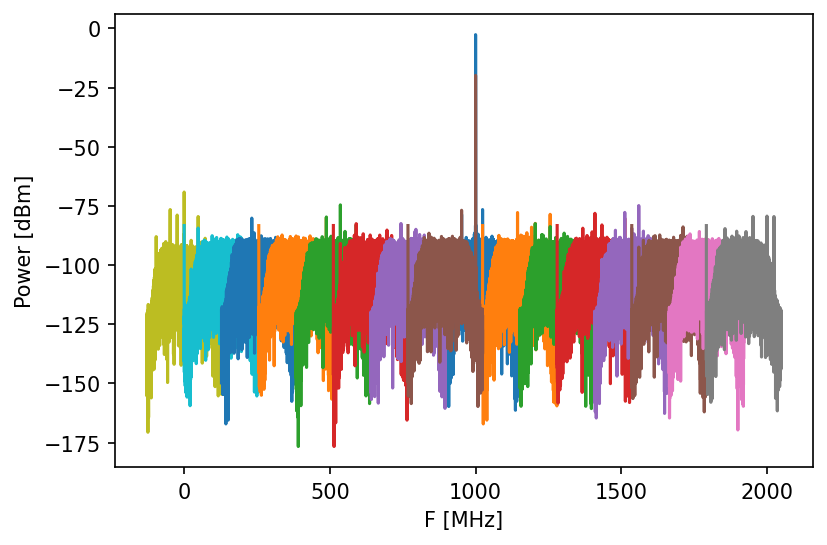

In [9]:
###########################################
### Channels Side-by-Side (XFFT output) ###
###########################################
# Channels to plot.
K = np.arange(chain.nch)

plt.figure(6,dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    print("Iteration K = %d" %KK)
    # Channel center frequency.
    fck = chain.analysis.ch2freq(KK)
    
    # Get data.    
    [xi,xq] = chain.get_bin_xfft(fck+1)
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15
    
    # Scale by FFT length.
    x = x/soc.FFT_N

    # Spectrum.
    Y = fftshift(x)
    F = np.linspace(-chain.fs_ch/2,chain.fs_ch/2,len(Y))

    # Normalize to dBm.
    R = 50;
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

F1 = 1000.004, Y1 = -2.641
FFT Resolution: 7.8125 kHz


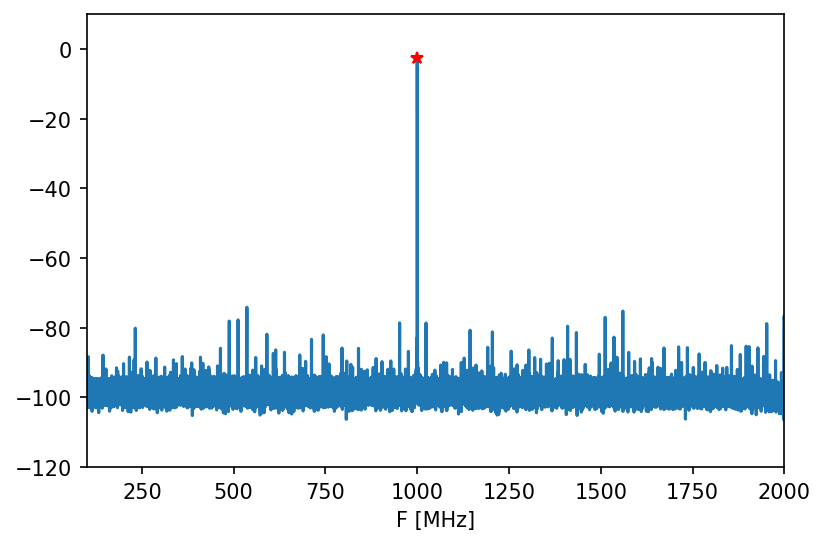

In [10]:
##########################################
### Simple Sine Loop-back (ACC output) ###
##########################################
# Number of averages.
N = 10

# Get data.
x = chain.get_data_acc(N)

# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by FFT length.
x = x/(soc.FFT_N)**2

# Spectrum.
Y = fftshift(x)
F = np.linspace(0,chain.fs,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(7,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");
plt.xlim([100,2000]);
plt.ylim([-120,10]);

print('FFT Resolution: {} kHz'.format(1000*soc['analysis'][0]['fs_ch']/soc.FFT_N))

# Now let's play a little with the standard part of the FW.

### Hardware Configuration

You should cable the board in loopback, connecting one DAC to one ADC. You can set appropriate generator and readout numbers in the cell below, which will be used in `res_ch` and `ro_chs` entries in the program dictionaries below.

For example, for a ZCU111 you might connect DAC228_T0_CH0_P to ADC226_T2_CH0_P (these are the labels on the XM500 balun board). The DAC and ADC lists tell you that these are DAC tile 0, block 0, and ADC tile 2, block 0. The generator and readout lists tell you that these are driven by generator 0 and readout 0, and your QICK programs will reference those IDs.

In [ ]:
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.30
FREQ = 500

In [ ]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");